<a href="https://colab.research.google.com/github/dpredie/SingleHDR/blob/master/SingleHDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[CVPR 2020] Single-Image HDR Reconstruction by Learning to Reverse the Camera Pipeline**

[project website](https://www.cmlab.csie.ntu.edu.tw/~yulunliu/SingleHDR)

In [ ]:
# fetch python code and pre-trained weights
!wget "https://www.cmlab.csie.ntu.edu.tw/~yulunliu/SingleHDR_/code_and_ckpt.zip"
!unzip code_and_ckpt.zip

--2021-10-02 10:39:36--  https://www.cmlab.csie.ntu.edu.tw/~yulunliu/SingleHDR_/code_and_ckpt.zip
Resolving www.cmlab.csie.ntu.edu.tw (www.cmlab.csie.ntu.edu.tw)... 140.112.29.134
Connecting to www.cmlab.csie.ntu.edu.tw (www.cmlab.csie.ntu.edu.tw)|140.112.29.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261161688 (249M) [application/zip]
Saving to: ‘code_and_ckpt.zip’

code_and_ckpt.zip   100%[===================>] 249.06M  18.0MB/s    in 15s     

2021-10-02 10:39:52 (16.9 MB/s) - ‘code_and_ckpt.zip’ saved [261161688/261161688]

Archive:  code_and_ckpt.zip
   creating: ckpt_deq_lin_hal_ref/
  inflating: ckpt_deq_lin_hal_ref/model.ckpt.data-00000-of-00001  
  inflating: ckpt_deq_lin_hal_ref/model.ckpt.index  
  inflating: ckpt_deq_lin_hal_ref/model.ckpt.meta  
  inflating: dequantization_net.py   
  inflating: hallucination_net.py    
  inflating: invemor.txt             
  inflating: linearization_net.py    
  inflating: net.py                  
  infla

In [ ]:
# run single-image HDR reconstruction on the uploaded image
# output: output.hdr
!pip install --upgrade tensorlayer==1.11.0

%tensorflow_version 1.x


In [ ]:
# upload your own LDR image (png or jpg)
import os
from google.colab import files
uploaded = files.upload()
for uploaded_image_name, _ in uploaded.items() :
    print(uploaded_image_name)

Saving ggg.jpg to ggg (1).jpg
ggg.jpg


In [ ]:


import argparse
import os
import tensorflow as tf
tf.reset_default_graph()
from dequantization_net import Dequantization_net
from linearization_net import Linearization_net
import hallucination_net
from refinement_net import Refinement_net
from util import apply_rf
import numpy as np
import cv2
import glob

_clip = lambda x: tf.clip_by_value(x, 0, 1)

def build_graph(
        ldr,  # [b, h, w, c]
        is_training,
):
    with tf.variable_scope("Dequantization_Net", reuse=tf.AUTO_REUSE):
        dequantization_model = Dequantization_net(is_train=is_training)
        C_pred = _clip(dequantization_model.inference(ldr))

    lin_net = Linearization_net()
    pred_invcrf = lin_net.get_output(C_pred, is_training)
    B_pred = apply_rf(C_pred, pred_invcrf)

    thr = 0.12
    alpha = tf.reduce_max(B_pred, reduction_indices=[3])
    alpha = tf.minimum(1.0, tf.maximum(0.0, alpha - 1.0 + thr) / thr)
    alpha = tf.reshape(alpha, [-1, tf.shape(B_pred)[1], tf.shape(B_pred)[2], 1])
    alpha = tf.tile(alpha, [1, 1, 1, 3])
    with tf.variable_scope("Hallucination_Net", reuse=tf.AUTO_REUSE):
        net_test, vgg16_conv_layers_test = hallucination_net.model(B_pred, 1, False)
        y_predict_test = net_test.outputs
        y_predict_test = tf.nn.relu(y_predict_test)
        A_pred = (B_pred) + alpha * y_predict_test

    # Refinement-Net
    with tf.variable_scope("Refinement_Net", reuse=tf.AUTO_REUSE):
        refinement_model = Refinement_net(is_train=is_training)
        refinement_output = tf.nn.relu(refinement_model.inference(tf.concat([A_pred, B_pred, C_pred], -1)))


    return refinement_output

ldr = tf.placeholder(tf.float32, [None, None, None, 3])
is_training = tf.placeholder(tf.bool)

HDR_out = build_graph(ldr, is_training)


class Tester:

    def __init__(self):
        return

    def test_it(self):
        ldr_img_path = uploaded_image_name
        print(ldr_img_path)
        ldr_img = cv2.imread(ldr_img_path)

        ldr_val = np.flip(ldr_img, -1).astype(np.float32) / 255.0

        ORIGINAL_H = ldr_val.shape[0]
        ORIGINAL_W = ldr_val.shape[1]

        """resize to 64x"""
        if ORIGINAL_H % 64 != 0 or ORIGINAL_W % 64 != 0:
            RESIZED_H = int(np.ceil(float(ORIGINAL_H) / 64.0)) * 64
            RESIZED_W = int(np.ceil(float(ORIGINAL_W) / 64.0)) * 64
            ldr_val = cv2.resize(ldr_val, dsize=(RESIZED_W, RESIZED_H), interpolation=cv2.INTER_CUBIC)
        
        padding = 32
        ldr_val = np.pad(ldr_val, ((padding, padding), (padding, padding), (0, 0)), 'symmetric')

        HDR_out_val = sess.run(HDR_out, {
            ldr: [ldr_val],
            is_training: False,
        })

        HDR_out_val = np.flip(HDR_out_val[0], -1)
        HDR_out_val = HDR_out_val[padding:-padding, padding:-padding]
        if ORIGINAL_H % 64 != 0 or ORIGINAL_W % 64 != 0:
            HDR_out_val = cv2.resize(HDR_out_val, dsize=(ORIGINAL_W, ORIGINAL_H), interpolation=cv2.INTER_CUBIC)
        cv2.imwrite('output.hdr', HDR_out_val)


        return

# ---

sess = tf.Session()
restorer = tf.train.Saver()
restorer.restore(sess, 'ckpt_deq_lin_hal_ref/model.ckpt')

tester = Tester()

tester.test_it()

[None, None, None, 3]
[TL] InputLayer  Hallucination_Net/input_layer: (?, ?, ?, 3)
[TL] InputLayer  Hallucination_Net/encoder/input_layer_bgr: (?, ?, ?, 3)
[TL] Conv2dLayer Hallucination_Net/encoder/h1/conv_1: shape: [3, 3, 3, 64] strides: [1, 1, 1, 1] pad: SAME act: relu
[TL] Conv2dLayer Hallucination_Net/encoder/h1/conv_2: shape: [3, 3, 64, 64] strides: [1, 1, 1, 1] pad: SAME act: relu
[TL] PoolLayer Hallucination_Net/encoder/h1/pool: ksize: [1, 2, 2, 1] strides: [1, 2, 2, 1] padding: SAME pool: max_pool
[TL] Conv2dLayer Hallucination_Net/encoder/h2/conv_1: shape: [3, 3, 64, 128] strides: [1, 1, 1, 1] pad: SAME act: relu
[TL] Conv2dLayer Hallucination_Net/encoder/h2/conv_2: shape: [3, 3, 128, 128] strides: [1, 1, 1, 1] pad: SAME act: relu
[TL] PoolLayer Hallucination_Net/encoder/h2/pool: ksize: [1, 2, 2, 1] strides: [1, 2, 2, 1] padding: SAME pool: max_pool
[TL] Conv2dLayer Hallucination_Net/encoder/h3/conv_1: shape: [3, 3, 128, 256] strides: [1, 1, 1, 1] pad: SAME act: relu
[TL] Con

In [ ]:
# fetch Photomatix for tone mapping
!wget "https://hdrsoft.com/download/linux/PhotomatixCL-6.0.tar.gz"
!tar xf PhotomatixCL-6.0.tar.gz

--2021-10-02 10:42:53--  https://hdrsoft.com/download/linux/PhotomatixCL-6.0.tar.gz
Resolving hdrsoft.com (hdrsoft.com)... 209.212.159.182
Connecting to hdrsoft.com (hdrsoft.com)|209.212.159.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3827098 (3.6M) [application/x-gzip]
Saving to: ‘PhotomatixCL-6.0.tar.gz’

PhotomatixCL-6.0.ta 100%[===================>]   3.65M  --.-KB/s    in 0.1s    

2021-10-02 10:42:53 (29.8 MB/s) - ‘PhotomatixCL-6.0.tar.gz’ saved [3827098/3827098]



In [ ]:
# tone map the HDR image
# output: output.jpg
!rm output.jpg
!PhotomatixCL/PhotomatixCL -t1 -o output -d ./ -s jpg output.hdr

rm: cannot remove 'output.jpg': No such file or directory
Tone Mapping with Details Enhancer...


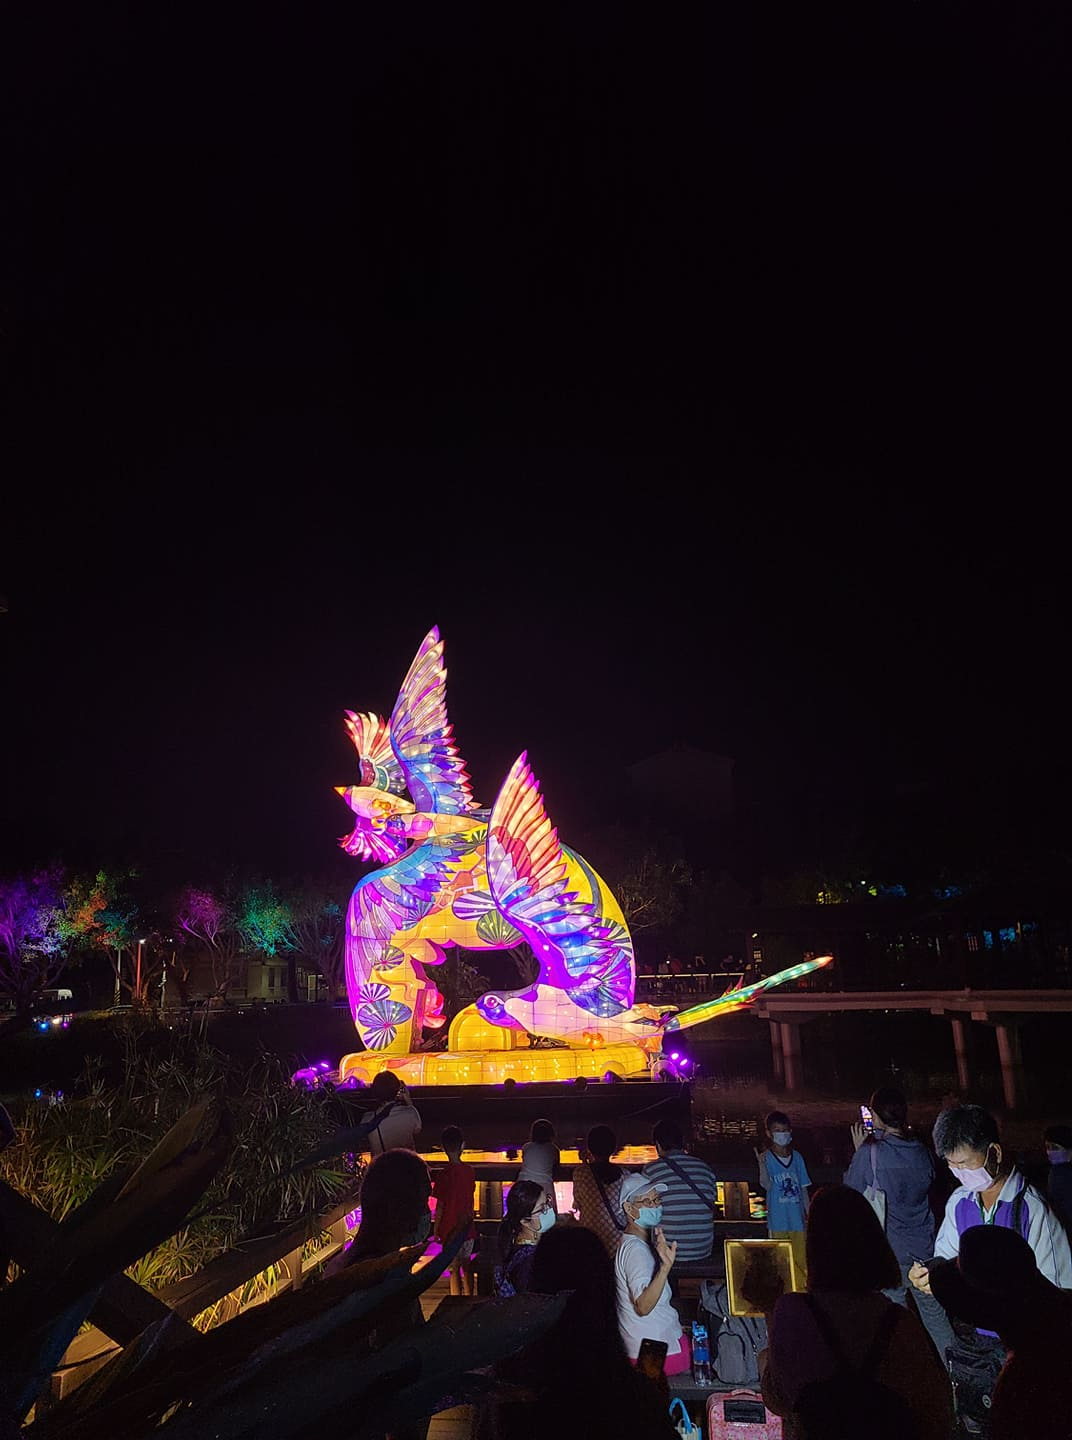

Input LDR image




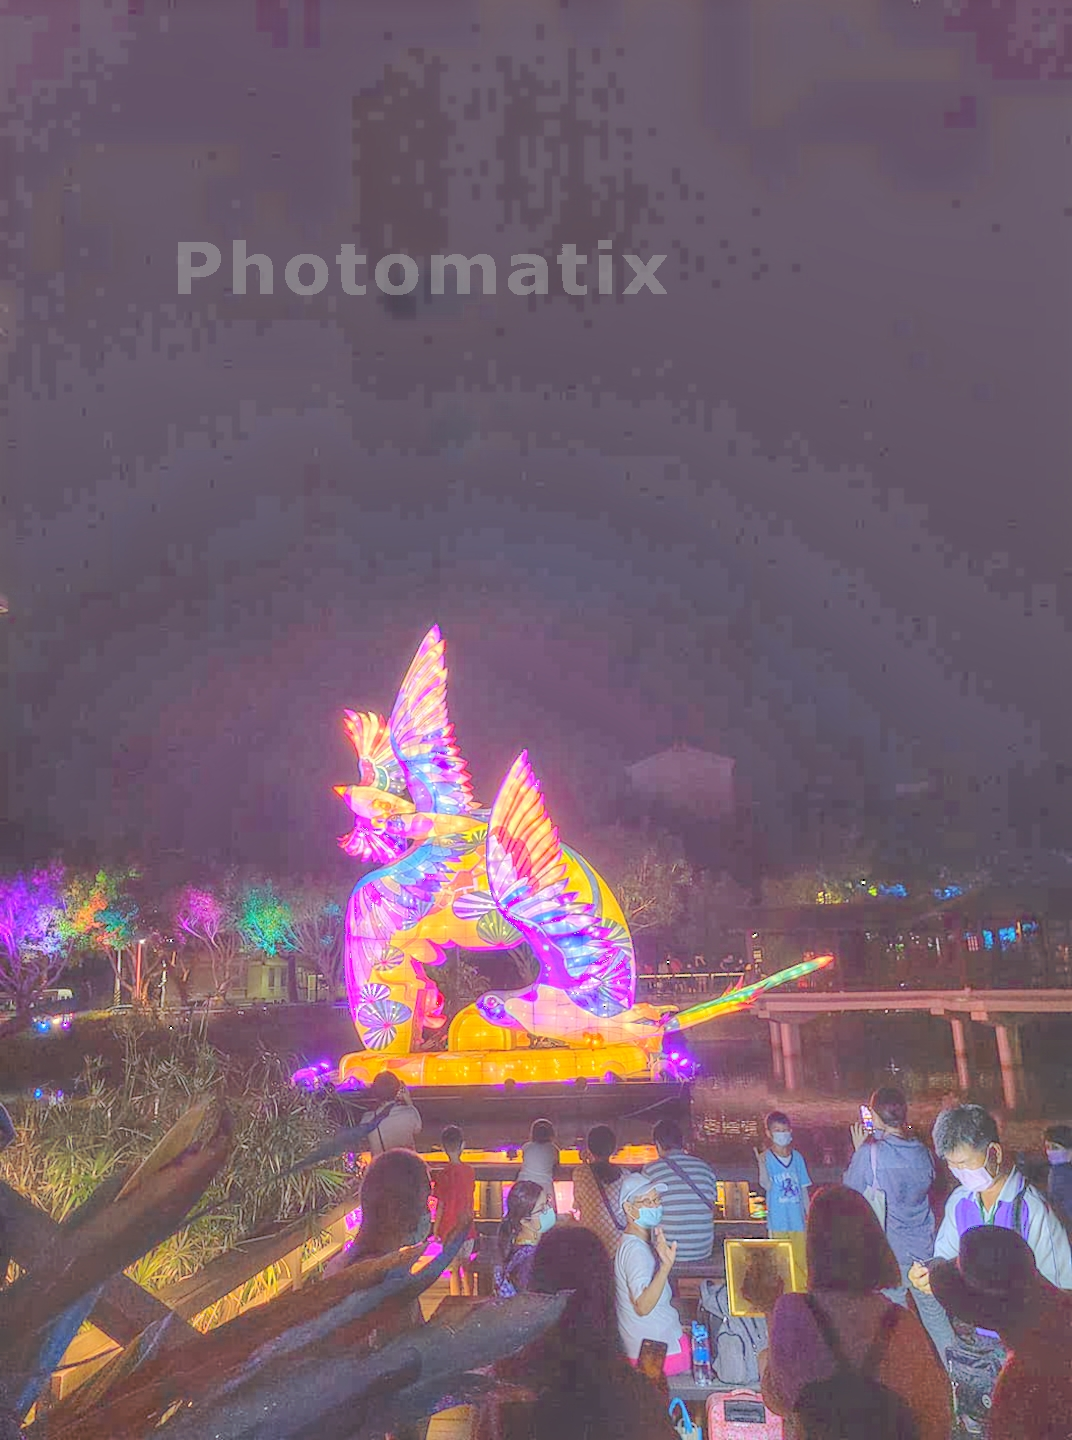

Output HDR image


In [ ]:
# show the input and output images
import cv2
from google.colab.patches import cv2_imshow
LDR = cv2.imread(uploaded_image_name)
cv2_imshow(LDR)
print('Input LDR image')
print('\n')
HDR = cv2.imread('output.jpg')
cv2_imshow(HDR)
print('Output HDR image')